### Finding the nearest non-nan node to each transect point

1) We do this by first selecting a single timeslice to be evaluated. time step 3 is chosen. It is assumed the the nan/dry points in this timestep will have nan values in all others
2) Creating a function that for each transect point calculates the distance between the transect point and all era5 nodes 361*720
3) Then for said transect point, it seaches within a search radius usuallly ~3degrees and filters out the nan points using np.isfinite method
4) It then saves Hs the value of the closest point.
5) Difficulty arrises when we try to trace back from this 1D value to the 2D equivalent lon-lat
6) keen attention needs to be paid to the search radius, because if the distance filtered dataset is too short, it will not be able to find the hs result eg in the Northern sea of japan, arabian gulf and northern russia where there are no ERA5 values but there are transects present. If it is too big however,then you run the risk of having duplicate values.
7) In the end it was decided to use the ERA5 resulting transect --> nearest offshore node mapping results for the GCM simulations
8) Keep in mind ERA5 and the GCM has latitudes switched, so flip the  max and min latitudes when doing isel

The following notebook describes this endeavor:


In [8]:
# %pip install pystac_client==0.4
# %pip install plotly

In [1]:
import pystac_client
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px

from tqdm import tqdm


In [2]:
# opening STAC catalog

catalog = pystac_client.Client.open(
    "https://storage.googleapis.com/dgds-data-public/gca/SOTC/gca-stac_sotc/catalog.json" # cloud API
    # r"p:\1000545-054-globalbeaches\15_GlobalCoastalAtlas\coclicodata\current\catalog.json" # P drive API 
)
catalog

<Client id=gca-catalog>

In [3]:
list(catalog.get_collections())

[<CollectionClient id=shore_mon_fut>,
 <CollectionClient id=sed_class>,
 <CollectionClient id=shore_mon>,
 <CollectionClient id=world_pop>,
 <CollectionClient id=world_gdp>,
 <CollectionClient id=shore_mon_hr>,
 <CollectionClient id=shore_mon_drivers>,
 <CollectionClient id=esl_gwl>,
 <CollectionClient id=sub_threat>,
 <CollectionClient id=Exp_world_pop>,
 <CollectionClient id=Exp_world_pop_parquet>,
 <CollectionClient id=Haz-ESL>,
 <CollectionClient id=Vul-Inf_Mort>,
 <CollectionClient id=Haz-GCM_90-100>,
 <CollectionClient id=Exp-NS_Slopes>,
 <CollectionClient id=Vul_MYS>,
 <CollectionClient id=Vul_RS>,
 <CollectionClient id=Haz-GCM_40-50>,
 <CollectionClient id=Haz-ERA5_04-14>,
 <CollectionClient id=Vul-GDP_Cap>,
 <CollectionClient id=Haz-GCM_04-14>,
 <CollectionClient id=Haz-Land_Sub_2010_COGs>,
 <CollectionClient id=Haz-Land_Sub_2040_COGs>,
 <CollectionClient id=Vul-Roads_Density_COGs>,
 <CollectionClient id=Exp-Delta_DEM_COGs>]

In [4]:
collection=catalog.get_child("Haz-ERA5_04-14")
collection

<CollectionClient id=Haz-ERA5_04-14>

In [5]:
href = collection.assets["data"].href
ds = xr.open_zarr(href)
ds

<xarray.Dataset>
Dimensions:    (latitude: 361, longitude: 720, time: 96432)
Coordinates:
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * time       (time) datetime64[ns] 2004-01-01 ... 2014-12-31T23:00:00
Data variables:
    swh        (time, latitude, longitude) float32 dask.array<chunksize=(1, 361, 720), meta=np.ndarray>
Attributes: (12/22)
    AUTHOR:              European Copernicus Marine Service
    CITATION:            European Copernicus Marine Service. (Year). Reanalys...
    COMMENT:             The dataset represents the significant height of com...
    CRS:                 EPSG:4326
    Conventions:         CF-1.8
    DESCRIPTION:         Significant Height of Combined Wind Waves and Swell ...
    ...                  ...
    TAGS:                ['significant height', 'wind waves', 'swell', 'ocean...
    TEMPORAL_EXTENT:     ['2004-01-01T00:00:00Z', '2014-12-31T23:59:59Z']
    TITLE:               Significant Height of Combined Wind Waves and Swell
    TITLE_ABBREVIATION:  SWH
    UNITS:               meters
    history:             2024-02-13 08:37:09 GMT by grib_to_netcdf-2.25.1: /o...

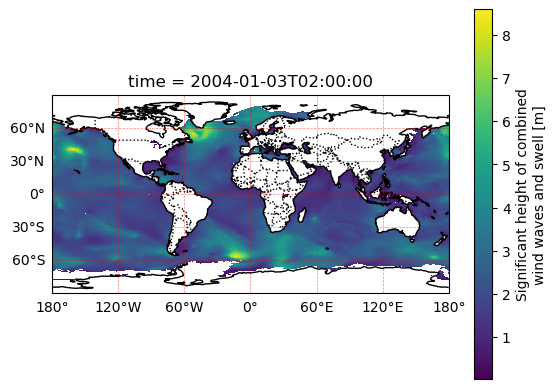

In [6]:


# Create a map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the variable
ds.isel(time=50)["swh"].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add features like coastlines, borders, and ocean
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='black')
# ax.add_feature(cartopy.feature.OCEAN)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='red', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Set the title
# plt.title('Wave Height')

# Show the plot
plt.show()

In [7]:
#Change longitude coordinate
def longitude_coverter(lon):
    if lon <0:
        lon=lon+360
    else:
        lon=lon
    return lon

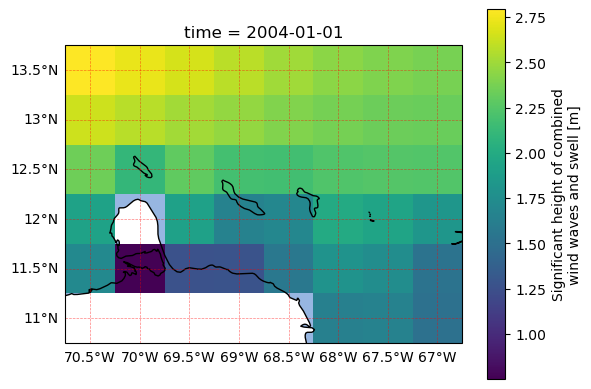

In [13]:

lon_min=-66.985558489
lon_max=-70.897144235

var="swh"
time_step=0
lat_min=10.641308809
lat_max=13.734711864


# #Change longitude coordinate
# def longitude_coverter(lon_min, lon_max)
#     lon_span=[lon_min,lon_max]

#     for i,lon in enumerate(lon_span):
#         if lon <0:
#             lon_span[i]=lon+360
#         else:
#             lon_span[i]=lon
#     return lon_span

# #Change longitude coordinate
# def longitude_coverter(lon):
#         if lon <0:
#             lon=lon+360
#         else:
#             lon=lon
#         return lon

lon_span=[longitude_coverter(lon_min),longitude_coverter(lon_max)]





# Create a map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the variable
ds.isel(time=time_step).sel(longitude=slice(np.min(lon_span),np.max(lon_span)),latitude=slice(lat_max,lat_min))[var].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add features like coastlines, borders, and ocean
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='red', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Set the title
# plt.title('Wave Height')

# Show the plot
plt.show()

create a scatterplot

In [10]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 361, longitude: 720, time: 96432)
Coordinates:
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * time       (time) datetime64[ns] 2004-01-01 ... 2014-12-31T23:00:00
Data variables:
    swh        (time, latitude, longitude) float32 dask.array<chunksize=(1, 361, 720), meta=np.ndarray>
Attributes: (12/22)
    AUTHOR:              European Copernicus Marine Service
    CITATION:            European Copernicus Marine Service. (Year). Reanalys...
    COMMENT:             The dataset represents the significant height of com...
    CRS:                 EPSG:4326
    Conventions:         CF-1.8
    DESCRIPTION:         Significant Height of Combined Wind Waves and Swell ...
    ...                  ...
    TAGS:                ['significant height', 'wind waves', 'swell', 'ocean...
    TEMPORAL_EXTENT:     ['2004-01-01T00:00:00Z', '2014-12-31T23:59:59Z']
    TITLE:               Significant Height of Combined Wind Waves and Swell
    TITLE_ABBREVIATION:  SWH
    UNITS:               meters
    history:             2024-02-13 08:37:09 GMT by grib_to_netcdf-2.25.1: /o...

In [14]:
ds_f=ds.isel(time=3)
ds_f=ds_f.compute()

ds_f

<xarray.Dataset>
Dimensions:    (latitude: 361, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
    time       datetime64[ns] 2004-01-01T03:00:00
Data variables:
    swh        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/22)
    AUTHOR:              European Copernicus Marine Service
    CITATION:            European Copernicus Marine Service. (Year). Reanalys...
    COMMENT:             The dataset represents the significant height of com...
    CRS:                 EPSG:4326
    Conventions:         CF-1.8
    DESCRIPTION:         Significant Height of Combined Wind Waves and Swell ...
    ...                  ...
    TAGS:                ['significant height', 'wind waves', 'swell', 'ocean...
    TEMPORAL_EXTENT:     ['2004-01-01T00:00:00Z', '2014-12-31T23:59:59Z']
    TITLE:               Significant Height of Combined Wind Waves and Swell
    TITLE_ABBREVIATION:  SWH
    UNITS:               meters
    history:             2024-02-13 08:37:09 GMT by grib_to_netcdf-2.25.1: /o...

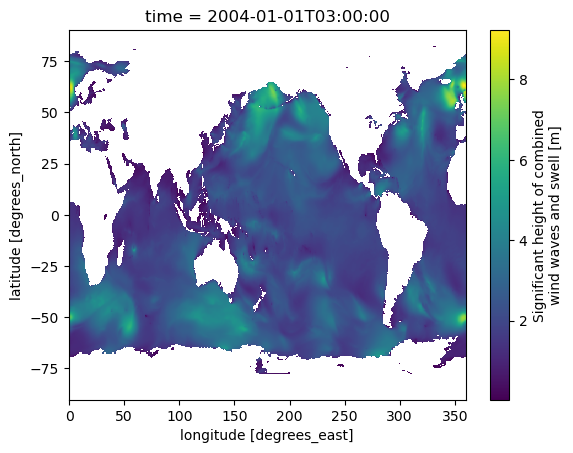

In [15]:
ds_f[var].plot()

Testing the method desctibed in the heading

In [19]:
lat=17.1423649741 #Arabian gulf example (data for ERA5 none for GCMs)
lon=42.4197296827
variable="swh"

#Find the distances between the point above (sample transect point) and all 361*720 ERA5 nodes
distances = np.sqrt((ds_f.latitude - lat)**2 + (ds_f.longitude - lon)**2)

# Find valid (non-NaN) values
valid_indices = np.isfinite(ds_f[variable])

# Exclude NaN values from consideration
valid_distances = distances.values[valid_indices.values]

# Find the nearest valid point
nearest_index = np.argmin(valid_distances)

# Get the value at the nearest valid point
nearest_value = ds_f[variable].values[valid_indices][nearest_index]


#Reduce the search radius around the transect point to reduce possibility of having the same value here 10degrees are used
reduced_selection=ds_f.sel(latitude=slice(lat+10,lat-10),longitude=slice(lon-10,lon+10))

# Find indices where 'hs' values in reduced_selection are equal to nearest_value (We can stop here)
indices = np.where(reduced_selection[variable].values == nearest_value)

# Extract latitude and longitude wave height values corresponding to the indices
nearest_lat = reduced_selection.latitude.values[indices[0][0]]
nearest_lon = reduced_selection.longitude.values[indices[1][0]]
nearest_value

0.33506203

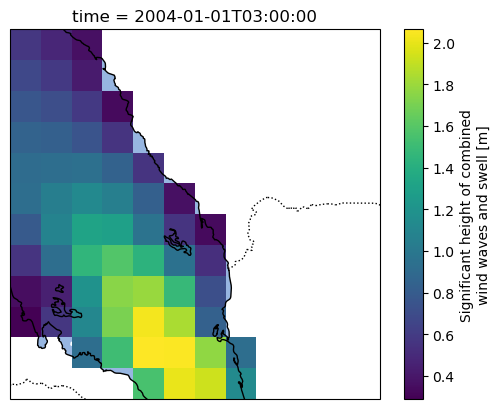

In [21]:
search_radius=3
ax = plt.axes(projection=ccrs.PlateCarree())
ds_f.sel(latitude=slice(lat+search_radius,lat-search_radius),longitude=slice(lon-search_radius,lon+search_radius))[var].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
# Add features like coastlines, borders, and ocean
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN)

In [22]:
####### Create a function from the above so it can be reused in a loop
# lat=-50.5
# lon=285.5
variable="swh"

def find_nearest_non_nan(ds_f, lat, lon,variable,search_radius):
    variable
    # Compute distances from the target point
    distances = np.sqrt((ds_f.latitude - lat)**2 + (ds_f.longitude - lon)**2)

    # Find valid (non-NaN) values
    valid_indices = np.isfinite(ds_f[variable])

    # Exclude NaN values from consideration
    valid_distances = distances.values[valid_indices.values]

    # Find the nearest valid point
    nearest_index = np.argmin(valid_distances)

    # Get the value at the nearest valid point
    nearest_value = ds_f[variable].values[valid_indices][nearest_index]
    nearest_value

    reduced_selection=ds_f.sel(latitude=slice(lat-search_radius,lat+search_radius),longitude=slice(lon-search_radius,lon+search_radius))

    #if there is 1 or less real value is within range the index of the nearest value is given
        
    if len(reduced_selection[variable].values[~np.isnan(reduced_selection[variable].values)])>1 :
        # Find indices where 'hs' values in reduced_selection are equal to nearest_value
        indices = np.where(reduced_selection[variable].values == nearest_value)

        # Extract latitude and longitude values corresponding to the indices
        nearest_lat = reduced_selection.latitude.values[indices[0][0]]
        nearest_lon = reduced_selection.longitude.values[indices[1][0]]
    
    if len(reduced_selection[variable].values[~np.isnan(reduced_selection[variable].values)])<=1:
        nearest_lat = ds_f.sel(latitude=lat,longitude=lon,method="nearest").latitude.values+0
        nearest_lon = ds_f.sel(latitude=lat,longitude=lon,method="nearest").longitude.values+0

    return nearest_lat, nearest_lon

In [24]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\04_Auxillary_files\Arjen_Vector_Template.csv")
df

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat
0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456
1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940
2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425
3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574
4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348
...,...,...,...,...,...,...,...,...,...,...
1739821,BOX_211_067_149,RUS,Europe,Russia,39.929937,64.701462,39.935198,64.698350,39.940460,64.695238
1739822,BOX_211_067_150,RUS,Europe,Russia,39.933577,64.702586,39.938839,64.699474,39.944100,64.696363
1739823,BOX_211_067_151,RUS,Europe,Russia,39.935546,64.703502,39.942003,64.700833,39.948460,64.698164
1739824,BOX_211_067_152,RUS,Europe,Russia,39.937050,64.704370,39.944697,64.702356,39.952343,64.700341


In [25]:
df["near_lat"]=np.nan
df["near_lon"]=np.nan
df

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,near_lat,near_lon
0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456,NaN,NaN
1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940,NaN,NaN
2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425,NaN,NaN
3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574,NaN,NaN
4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1739821,BOX_211_067_149,RUS,Europe,Russia,39.929937,64.701462,39.935198,64.698350,39.940460,64.695238,NaN,NaN
1739822,BOX_211_067_150,RUS,Europe,Russia,39.933577,64.702586,39.938839,64.699474,39.944100,64.696363,NaN,NaN
1739823,BOX_211_067_151,RUS,Europe,Russia,39.935546,64.703502,39.942003,64.700833,39.948460,64.698164,NaN,NaN
1739824,BOX_211_067_152,RUS,Europe,Russia,39.937050,64.704370,39.944697,64.702356,39.952343,64.700341,NaN,NaN



1) If the below loop runs smoothly then hurray!, if not that usually means the search radius was too small. 
2) you can examine and decide how to deal with these problem regions by plotting it and examining where has no data
find_nearest_non_nan(ds_f,lat,lon,variable,search_radius)
3) Solution is again to increase the search radius. this is also risky as it may cause attribute distant unrealistic waves to the shoreline transects
4) You can also just assign a nan however this has the repercussion of having large stretches of land with no data
5) The script usuallt takes 3hrs hence why it is smart do it once and save the results for the other GCM

In [ ]:
variable="swh"
search_radius=3
for i, (lat, lon) in tqdm(enumerate(zip(df["Intersect_lat"], df["Intersect_lon"])), desc="inserting slice", total=len(df)):
    # lat=-50.5
    if np.isnan(lat) | np.isnan(lon):
        continue
    lon=longitude_coverter(lon)
    df.iloc[i,10],df.iloc[i,11]=find_nearest_non_nan(ds_f,lat,lon,variable,search_radius)
df

In [82]:
df.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\All_Transects_ERA5map.csv")

In [31]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\All_Transects_ERA5map_ERA5_2014.csv")
df

,Unnamed: 0,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,near_lat,near_lon
0,0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456,-50.0,285.0
1,1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940,-50.0,285.0
2,2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425,-50.0,285.0
3,3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574,-50.0,285.0
4,4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348,-50.0,285.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739821,1739821,BOX_211_067_149,RUS,Europe,Russia,39.929937,64.701462,39.935198,64.698350,39.940460,64.695238,66.0,39.0
1739822,1739822,BOX_211_067_150,RUS,Europe,Russia,39.933577,64.702586,39.938839,64.699474,39.944100,64.696363,66.0,39.0
1739823,1739823,BOX_211_067_151,RUS,Europe,Russia,39.935546,64.703502,39.942003,64.700833,39.948460,64.698164,66.0,39.0
1739824,1739824,BOX_211_067_152,RUS,Europe,Russia,39.937050,64.704370,39.944697,64.702356,39.952343,64.700341,66.0,39.0


In [32]:
df["Lat_Lon"]=list(zip(df["near_lat"],df["near_lon"]))
df

,Unnamed: 0,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,near_lat,near_lon,Lat_Lon
0,0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456,-50.0,285.0,"(-50.0, 285.0)"
1,1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940,-50.0,285.0,"(-50.0, 285.0)"
2,2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425,-50.0,285.0,"(-50.0, 285.0)"
3,3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574,-50.0,285.0,"(-50.0, 285.0)"
4,4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348,-50.0,285.0,"(-50.0, 285.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739821,1739821,BOX_211_067_149,RUS,Europe,Russia,39.929937,64.701462,39.935198,64.698350,39.940460,64.695238,66.0,39.0,"(66.0, 39.0)"
1739822,1739822,BOX_211_067_150,RUS,Europe,Russia,39.933577,64.702586,39.938839,64.699474,39.944100,64.696363,66.0,39.0,"(66.0, 39.0)"
1739823,1739823,BOX_211_067_151,RUS,Europe,Russia,39.935546,64.703502,39.942003,64.700833,39.948460,64.698164,66.0,39.0,"(66.0, 39.0)"
1739824,1739824,BOX_211_067_152,RUS,Europe,Russia,39.937050,64.704370,39.944697,64.702356,39.952343,64.700341,66.0,39.0,"(66.0, 39.0)"


In [33]:
df.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\All_Transects_ERA5map_2014_zip_added.csv")

In [86]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\All_Transects_ERA5map_2014_zip_added.csv")
df

,Unnamed: 0.1,Unnamed: 0,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,near_lat,near_lon,Lat_Lon
0,0,0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456,-50.5,285.5,"(-50.5, 285.5)"
1,1,1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940,-50.5,285.5,"(-50.5, 285.5)"
2,2,2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425,-50.5,285.5,"(-50.5, 285.5)"
3,3,3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574,-50.5,285.5,"(-50.5, 285.5)"
4,4,4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348,-50.5,285.5,"(-50.5, 285.5)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739821,1739821,1739821,BOX_211_067_149,RUS,Europe,Russia,39.929937,64.701462,39.935198,64.698350,39.940460,64.695238,64.5,40.0,"(64.5, 40.0)"
1739822,1739822,1739822,BOX_211_067_150,RUS,Europe,Russia,39.933577,64.702586,39.938839,64.699474,39.944100,64.696363,64.5,40.0,"(64.5, 40.0)"
1739823,1739823,1739823,BOX_211_067_151,RUS,Europe,Russia,39.935546,64.703502,39.942003,64.700833,39.948460,64.698164,64.5,40.0,"(64.5, 40.0)"
1739824,1739824,1739824,BOX_211_067_152,RUS,Europe,Russia,39.937050,64.704370,39.944697,64.702356,39.952343,64.700341,64.5,40.0,"(64.5, 40.0)"


In [34]:
#Find the unique values to prevent recalculations

unique_points=df["Lat_Lon"].unique()
unique_points

array([(-50.0, 285.0), (-47.5, 285.0), (-48.5, 284.5), ..., (66.0, 39.0),
       (65.0, 37.0), (65.5, 38.0)], dtype=object)

In [35]:
len(unique_points)

5928

In [36]:
x_list=[]
y_list=[]

for x,y in tqdm(unique_points,desc="creating dataframe"):
    x_list.append(x)
    y_list.append(y)

df_unique = pd.DataFrame({
    'lat': x_list,
    'lon': y_list,
    'lat_lon': unique_points
})
df_unique

creating dataframe: 100%|██████████| 5928/5928 [00:00<00:00, 593919.22it/s]


,lat,lon,lat_lon
0,-50.0,285.0,"(-50.0, 285.0)"
1,-47.5,285.0,"(-47.5, 285.0)"
2,-48.5,284.5,"(-48.5, 284.5)"
3,-49.0,284.5,"(-49.0, 284.5)"
4,-53.5,286.5,"(-53.5, 286.5)"
...,...,...,...
5923,65.0,37.5,"(65.0, 37.5)"
5924,65.5,38.5,"(65.5, 38.5)"
5925,66.0,39.0,"(66.0, 39.0)"
5926,65.0,37.0,"(65.0, 37.0)"


## Save the unique results mapper, this can now be used for the ERA5 and GCM mappings

In [37]:
df_unique.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\Unique_Points_no_nan_ERA5_2014.csv",index=False)

In [38]:
df_unique=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\Unique_Points_no_nan_ERA5_2014.csv")
df_unique

,lat,lon,lat_lon
0,-50.0,285.0,"(-50.0, 285.0)"
1,-47.5,285.0,"(-47.5, 285.0)"
2,-48.5,284.5,"(-48.5, 284.5)"
3,-49.0,284.5,"(-49.0, 284.5)"
4,-53.5,286.5,"(-53.5, 286.5)"
...,...,...,...
5923,65.0,37.5,"(65.0, 37.5)"
5924,65.5,38.5,"(65.5, 38.5)"
5925,66.0,39.0,"(66.0, 39.0)"
5926,65.0,37.0,"(65.0, 37.0)"


In [39]:
import plotly.express as px


# Plotting using Plotly Express with Mapbox
fig = px.scatter_mapbox(df_unique, 
                        lat='lat', 
                        lon='lon', 
                        hover_data=['lat_lon'],
                        mapbox_style="carto-positron")
fig.show()

### To observe how the previous method using the built in nearest function from xr.sel(blah, method="nearest") gives values inland

In [40]:

df_unique_old=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\Unique_Points_before_nan_removal algorithm.csv")
df_unique_old

,lat,lon,lat_lon
0,-50.5,285.5,"(-50.5, 285.5)"
1,-50.5,286.0,"(-50.5, 286.0)"
2,-47.5,285.0,"(-47.5, 285.0)"
3,-48.5,284.5,"(-48.5, 284.5)"
4,-49.0,284.5,"(-49.0, 284.5)"
...,...,...,...
8253,65.0,37.0,"(65.0, 37.0)"
8254,65.5,40.0,"(65.5, 40.0)"
8255,64.5,36.5,"(64.5, 36.5)"
8256,64.5,40.5,"(64.5, 40.5)"


In [41]:
# Filter for inland points ie the differences and plot them as red
df_nan = df_unique_old[~df_unique_old['lat_lon'].isin(df_unique['lat_lon'])].copy()
df_nan

,lat,lon,lat_lon
0,-50.5,285.5,"(-50.5, 285.5)"
1,-50.5,286.0,"(-50.5, 286.0)"
6,-52.5,288.0,"(-52.5, 288.0)"
7,-53.0,287.5,"(-53.0, 287.5)"
8,-52.5,285.5,"(-52.5, 285.5)"
...,...,...,...
8251,64.0,37.5,"(64.0, 37.5)"
8254,65.5,40.0,"(65.5, 40.0)"
8255,64.5,36.5,"(64.5, 36.5)"
8256,64.5,40.5,"(64.5, 40.5)"


In [46]:
import plotly.express as px



# Plotting using Plotly Express with Mapbox
fig = px.scatter_mapbox(df_nan, 
                        lat='lat', 
                        lon='lon',
                        color_discrete_sequence=['red'],# Set all markers to red 
                        hover_data=['lat_lon'],
                        mapbox_style="carto-positron",
                        title="Locations with NaN values")
# Adding trace for unique values
fig.add_trace(px.scatter_mapbox(df_unique, 
                                lat='lat', 
                                lon='lon', 
                                color_discrete_sequence=['blue'],# Set all markers to blue
                                hover_data=['lat_lon'],
                                mapbox_style="carto-positron",
                                title="Unique Locations").data[0])

fig.show()


In [47]:
df_unique

,lat,lon,lat_lon
0,-50.0,285.0,"(-50.0, 285.0)"
1,-47.5,285.0,"(-47.5, 285.0)"
2,-48.5,284.5,"(-48.5, 284.5)"
3,-49.0,284.5,"(-49.0, 284.5)"
4,-53.5,286.5,"(-53.5, 286.5)"
...,...,...,...
5923,65.0,37.5,"(65.0, 37.5)"
5924,65.5,38.5,"(65.5, 38.5)"
5925,66.0,39.0,"(66.0, 39.0)"
5926,65.0,37.0,"(65.0, 37.0)"


In [ ]:
ds = xr.open_zarr(href)
ds

In [ ]:
selected_lons = df_unique["lon"].values
selected_lats = df_unique["lat"].values

# Selecting data based on specific coordinates
subset_data_coordinates = ds.sel(longitude=selected_lons, latitude=selected_lats)
subset_data_coordinates

<xarray.Dataset>
Dimensions:    (time: 32136, latitude: 8258, longitude: 8258)
Coordinates:
  * latitude   (latitude) float32 -50.5 -50.5 -47.5 -48.5 ... 64.5 64.5 64.5
  * longitude  (longitude) float32 285.5 286.0 285.0 284.5 ... 36.5 40.5 37.5
  * time       (time) datetime64[ns] 2090-01-01 ... 2100-12-31T21:00:00
Data variables:
    hs_1_26    (time, latitude, longitude) float32 dask.array<chunksize=(1, 8258, 8258), meta=np.ndarray>
    hs_5_85    (time, latitude, longitude) float32 dask.array<chunksize=(1, 8258, 8258), meta=np.ndarray>
Attributes: (12/36)
    AUTHOR:                        Commonwealth Scientific and Industrial Res...
    CITATION:                      CSIRO. (Year).  2090-2100 CMIP6 EC-EARTH S...
    COMMENT:                       The dataset includes significant wave heig...
    CRS:                           EPSG:4326
    Conventions:                   CF-1.8
    DESCRIPTION:                   The dataset contains projections of signif...
    ...                            ...
    northernmost_latitude:         90.
    product_name:                  ww3.209001_hs.nc
    southernmost_latitude:         -90.
    start_date:                    2090-01-01 00:00:00
    stop_date:                     2090-01-31 21:00:00
    westernmost_longitude:         0.